### Reinforcement Learning - Trading Strategy

We'll have the 3 components:
* policy development
* parameter optimization
* backtest

RL Components:
* Agent = Trading
* Action = Buy / Hold / Sell
* Reward = realized gains/loss
* Environment = Crypto Market Exchange

In [1]:
import pandas as pd
import pandas_datareader as pdr

import urllib.request as urlrq
import certifi
import ssl

In [1]:
import sys

14

In [8]:
date = '01/23/2003'
print(date[-4:])

2003


In [2]:
df = pdr.DataReader('ETH-USD','yahoo','01/01/2020')
df.sort_index(inplace=True)
df.to_csv('ETH_Jan2020_Nov2022.csv')

In [3]:
import numpy as np
from numpy.random import choice
import random

import pandas as pd
pd.options.display.width = 100
pd.options.display.max_rows = 500
pd.options.display.precision = 2

import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import math

from collections import deque
from IPython.core.debugger import set_trace

In [4]:
import warnings
warnings.filterwarnings('ignore')

#### Load dataset

In [5]:
df = pd.read_csv('ETH_Jan2020_Nov2022.csv', index_col=0) 

#### Exploratory Data Analysis

In [6]:
df.shape

(1048, 6)

In [7]:
df.tail(3)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-11-11,1302.30,1211.33,1298.88,1287.22,20920539099,1287.22
2022-11-12,1288.15,1242.15,1287.44,1255.27,10964962767,1255.27
2022-11-13,1271.57,1224.47,1255.41,1224.47,9486017536,1224.47


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1048 entries, 2020-01-01 to 2022-11-13
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       1048 non-null   float64
 1   Low        1048 non-null   float64
 2   Open       1048 non-null   float64
 3   Close      1048 non-null   float64
 4   Volume     1048 non-null   int64  
 5   Adj Close  1048 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 57.3+ KB


In [9]:
df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,1048.00,1048.00,1048.00,1048.00,1.05e+03,1048.00
mean,1765.59,1647.99,1710.47,1711.18,1.95e+10,1711.18
std,1336.66,1253.25,1298.31,1296.82,1.01e+10,1296.82
min,116.02,95.18,110.41,110.61,5.11e+09,110.61
25%,393.17,371.57,384.03,384.99,1.29e+10,384.99
50%,1651.63,1546.18,1591.80,1592.10,1.71e+10,1592.10
75%,2841.62,2643.29,2763.35,2763.88,2.30e+10,2763.88
max,4891.70,4718.04,4810.07,4812.09,8.45e+10,4812.09


<AxesSubplot:xlabel='Date'>

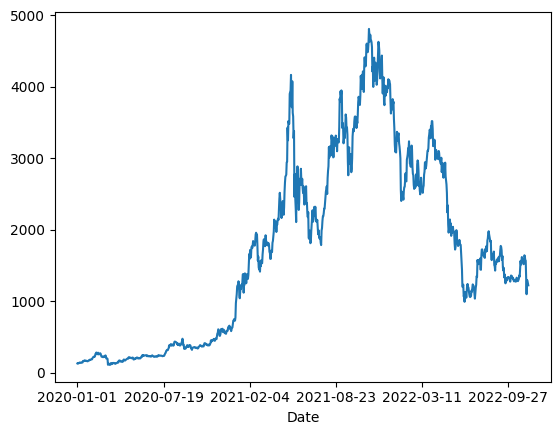

In [10]:
df['Close'].plot()

#### Data Cleaning

We check for null values

In [11]:
df.isnull().values.any()

False

If there were any missing val in ETH, then we would use ffill, just in case

In [12]:
df = df.fillna(method='ffill')

Train Test Split (80% train - 20% test)

In [13]:
df['Close'].dtype

dtype('float64')

In [14]:
X = list(df['Close'])
val_size = 0.2
train_size = int(len(X)*(1-val_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]

### DQN

We build the agent class.. the object from this class will be used for training phase and training model

In [15]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam

In [16]:
class Agent:
    #Constructor
    def __init__(self, state_size, is_eval=False, model_name=""):
        self.state_size = state_size #this is the window size, n previous days
        self.action_size = 3 # buy/sell/HODL
        self.memory = deque(maxlen=1000)
        self.inventory = []
        self.model_name = model_name
        self.is_eval = is_eval #lets me know if training is ongoing

        #epsilon greedy approach factor... We will try random condition first before optimizing. We add eps-greedy policy 
        #with eps=0.05. THIS IS TO PREVENT OVERFITTING
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995

        self.gamma = 0.95 #discount factor...agent prioritize short-term rewards > long-term rewards..lower=shift to long-term

        self.model = load_model(model_name) if is_eval else self.RL_model()
    
    #Now we build the Deep Q-Learn model that returns q-value when inputs are states at t=1,...,t=T
    def RL_model(self):
        model = Sequential() #from keras
        
        #Input layer
        model.add(Dense(units=64, input_dim=self.state_size, activation='relu'))

        #Hidden layers
        model.add(Dense(units=32, activation='relu'))
        model.add(Dense(units=8, activation='relu'))

        #Final Output Layer
        model.add(Dense(self.action_size, activation='linear')) # output dim = action size = buy/sell/HODL... (3)
        model.compile(loss='mse', optimizer=Adam(lr=0.001))
        return model

# We need to return action on value function with:
# - prob (1-eps)... action will be based on highest Q-value
# - prob (eps)... action will be randomly picked

#Basically, there's going to be higher epsilon in the initial phase, but as we train RL, it will later on be less... 
# We need to make an action

    #Action
    def actions(self, state):
        if not self.is_eval and random.random() <= self.epsilon: #If tested & self.eps still high... go random
            return random.randrange(self.action_size) 
        options = self.model.predict(state)
        return np.argmax(options[0]) #So.. choose the corresponding action based on highest q-value func

    #Memory.. so NN is trained based on observed experience.. stores state history/action/reward/next state experienced by agent
    # Takes in minibatch as inputs and updates Deep Q-model weights by minimizing loss function
    def exp_replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        
        for i in range(l-batch_size+1, l):
            mini_batch.append(self.memory[i])

        #memory during training
        for state, action, reward, next_state, done in mini_batch:
            # At time t... reward
            target=reward
            #update Q table from Q table eq
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            
            #Q-value of current state from table
            target_f = self.model.predict(state)
            #update Q table for output after action given
            target_f[0][action] = target
            #train and fit model when in X state... if Y state, target_f (target is updated)
            self.model.fit(state, target_f, epochs=1, verbose=0)
        
        #Finally implimenting the eps-greedy approach
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

#### Helper Function
get_state = states are used as input vector. we create time series by creating the states from vector\
* takes in 3 parameters: data, time (t), window(how many days back in time). RoC between the vectors is used as measurement and based on sigmoidal function

In [17]:
import os
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

In [18]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [19]:
def formatPrice(n):
    return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))

#Sigmoid Function
def sigmoid(x):
    return 1/(1+np.exp(-x))

#get state history
def get_state(data, t, n):
    d = t-n+1
    block = data[d:t+1] if d>=0 else -d*[data[0]]+data[0:t+1]
    res = []

    for i in range(n-1):
        res.append(sigmoid(block[i+1]-block[i]))
        return np.array([res])
#plot the charts
def plot_behavior(df_input, buy_states, sell_states, gains, name):
    fig = plt.figure(figsize=(20,8))
    plt.plot(df_input, color='b')
    plt.plot(df_input, 'v', color='r', label='Sell Signal', markevery=sell_states, markersize=8)
    plt.plot(df_input, '^', color='g', label='Buy Signal', markevery=buy_states, markersize=8)
    plt.legend()
    plt.title(name+' Total profits: %f'%(gains))
    save_fig(name, tight_layout=True)
    plt.show()



#### Train the data

Get current state -> devise action plan based on Q values -> Reward -> next state -> memory -> rinse and repeat until batch complete -> update Bellman eq -> get target Q value -> compare Q predicted with Q target and fit in ANN model -> Back to beginning

Goal is to maximize profits... remember, 3 actions: buy/sell/HODL.\
During training, the action is predicted from t,t+1,...,t=T... gains/losses/neutral price of action is calculated. Afterwards, the cumsum is calculated at the end of training period.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Running episode 0/15
Instructions for updating:
Use tf.cast instead.
--------------------------------
Total Profit: $543.59
--------------------------------
Saving figure Episode_0


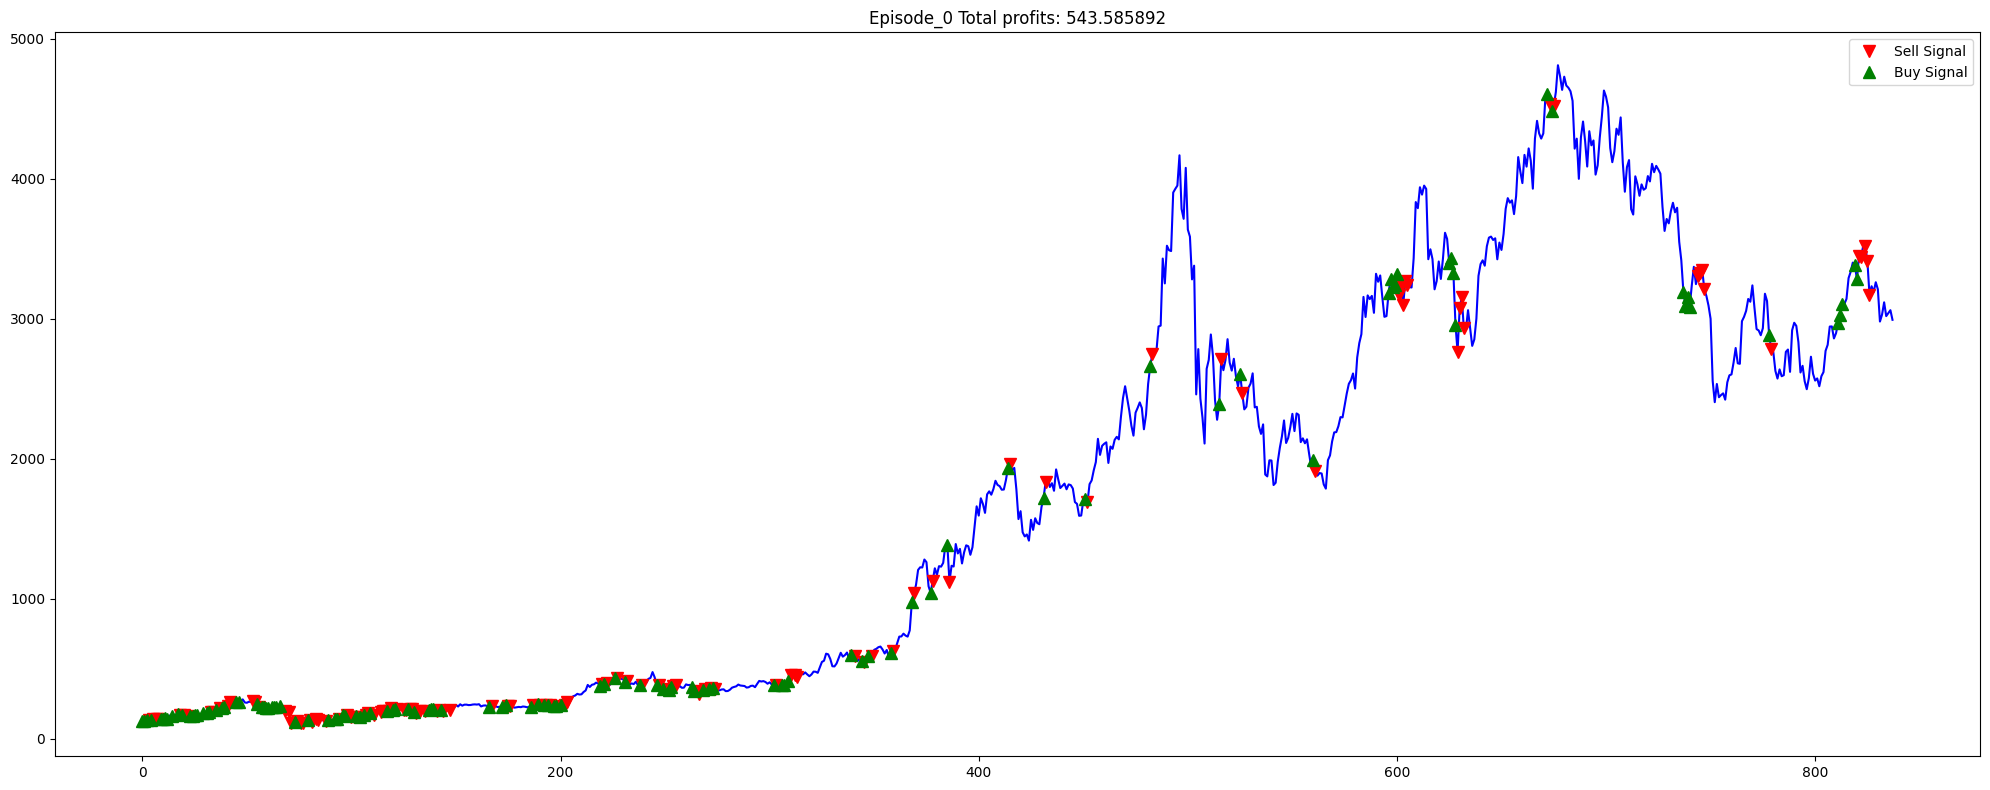

Running episode 1/15
--------------------------------
Total Profit: $6198.60
--------------------------------
Saving figure Episode_1


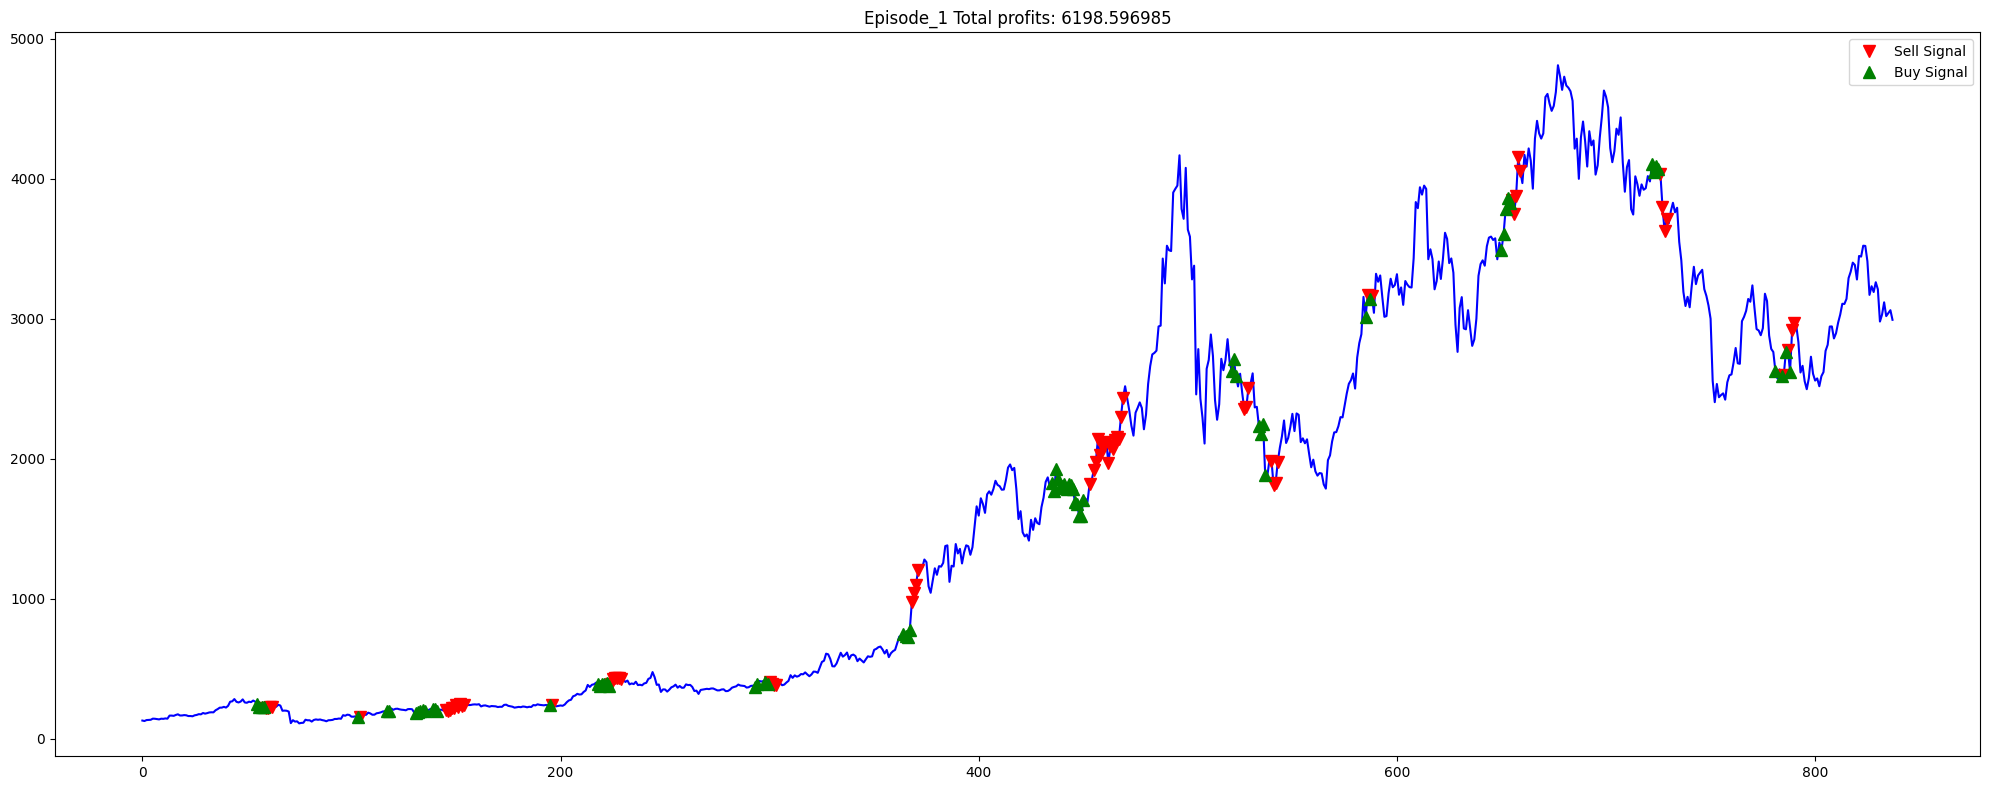

Running episode 2/15
--------------------------------
Total Profit: $3772.19
--------------------------------
Saving figure Episode_2


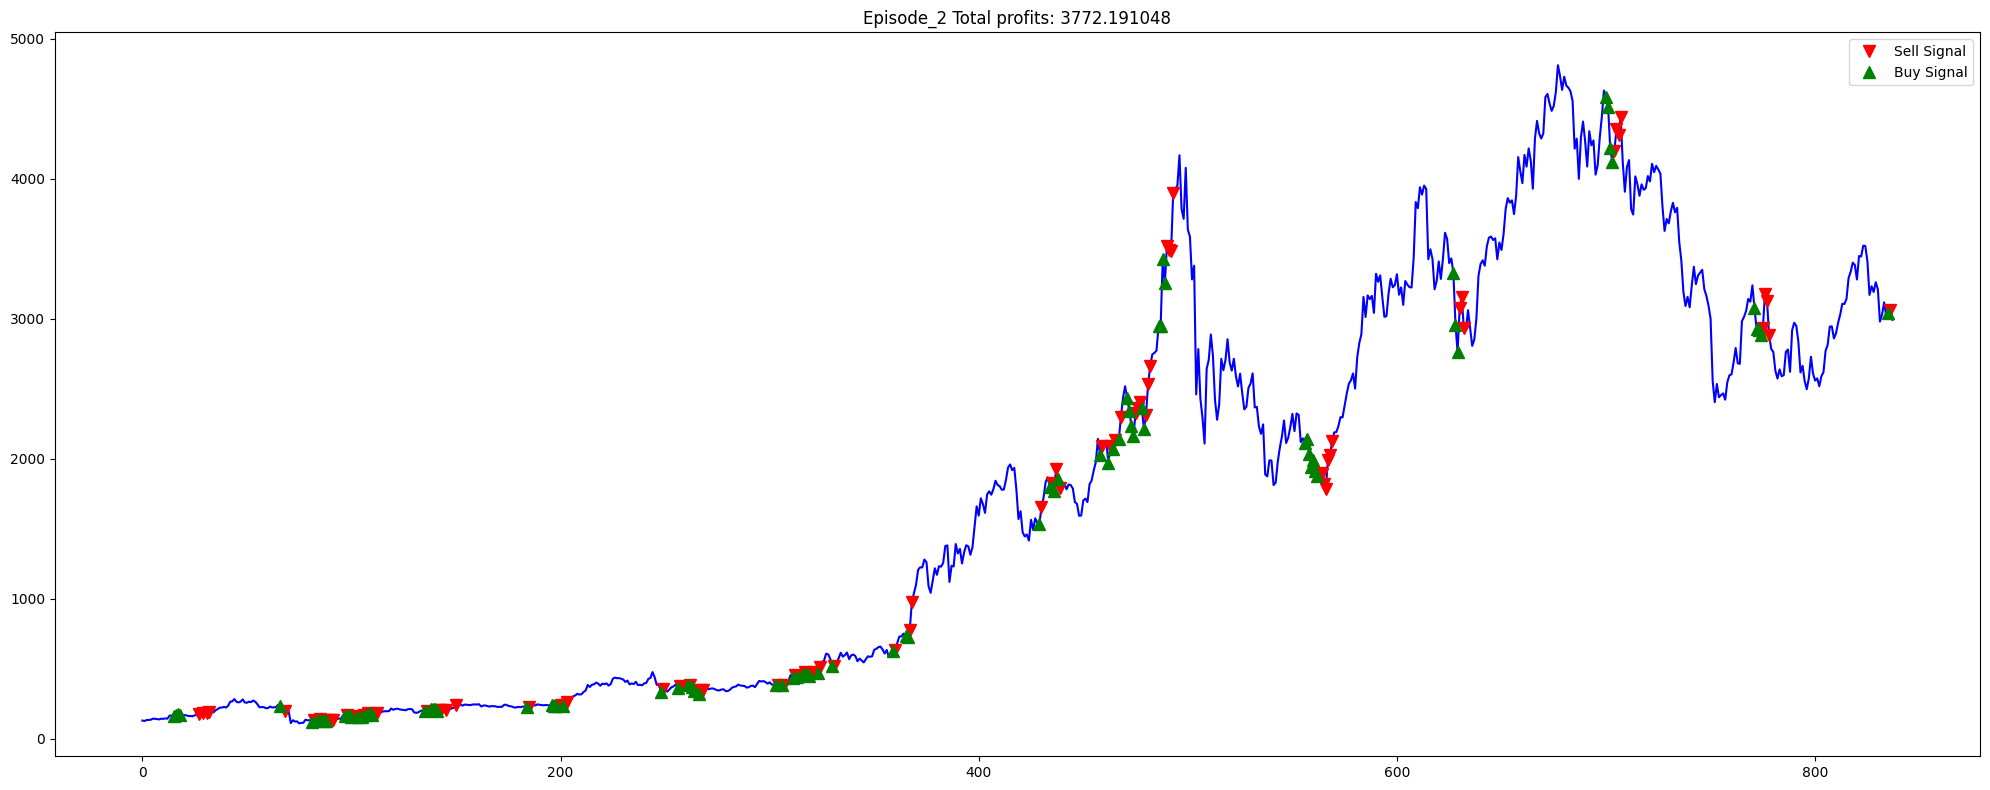

Running episode 3/15
--------------------------------
Total Profit: -$451.19
--------------------------------
Saving figure Episode_3


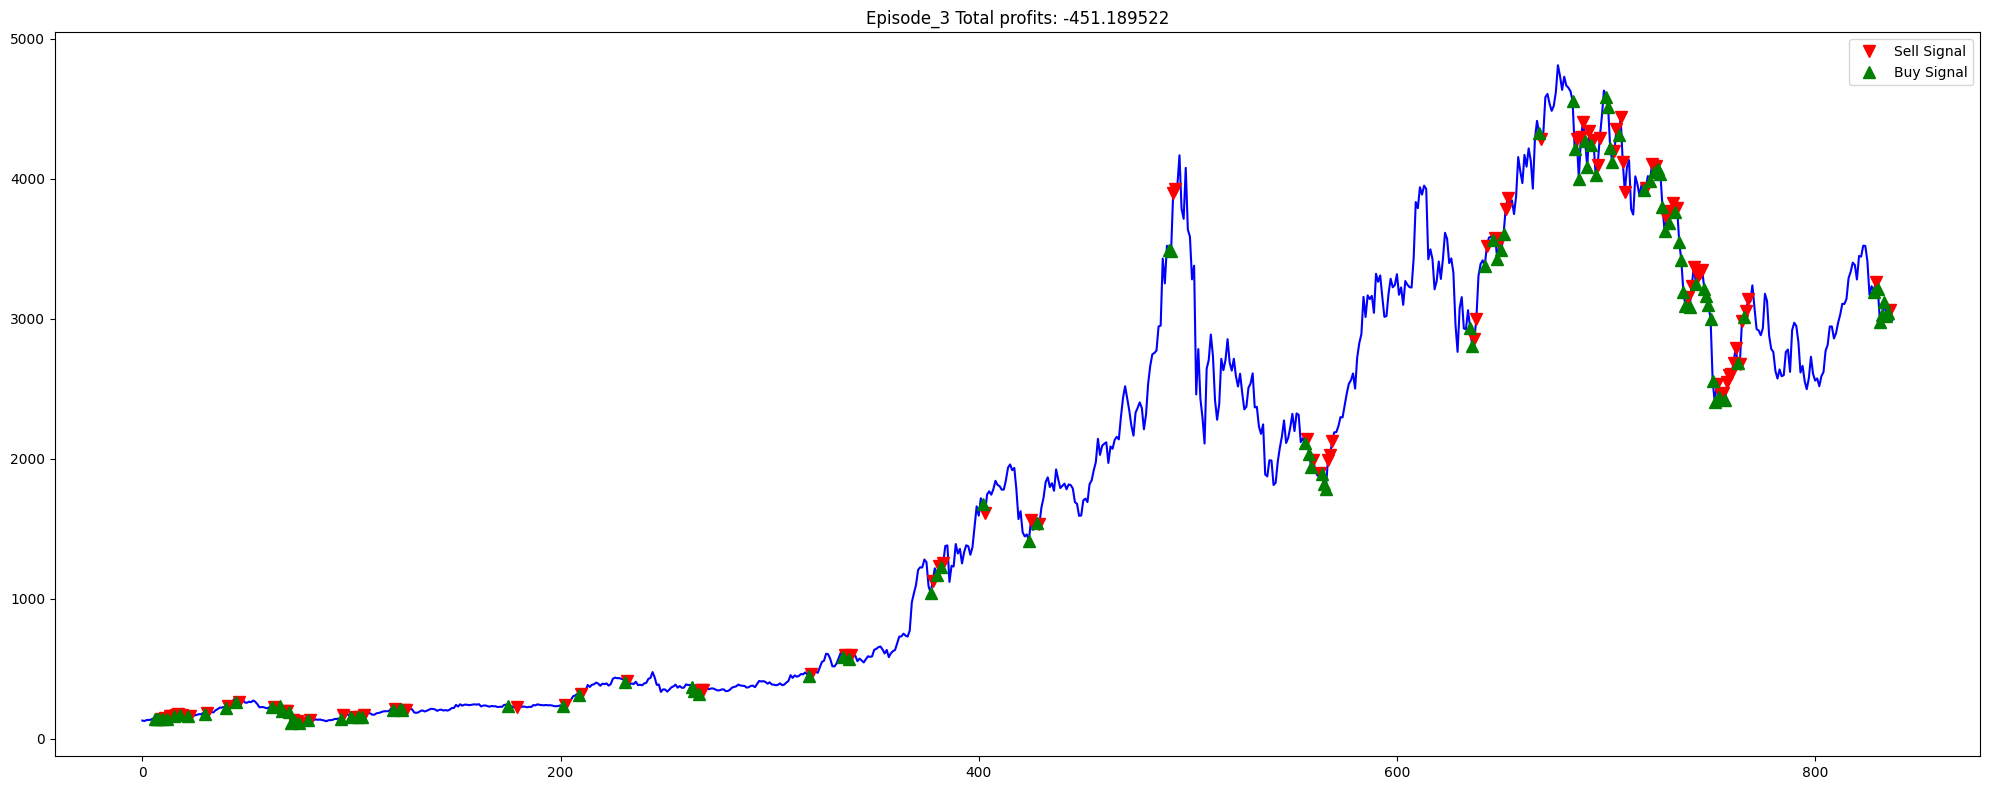

Running episode 4/15
--------------------------------
Total Profit: $1233.81
--------------------------------
Saving figure Episode_4


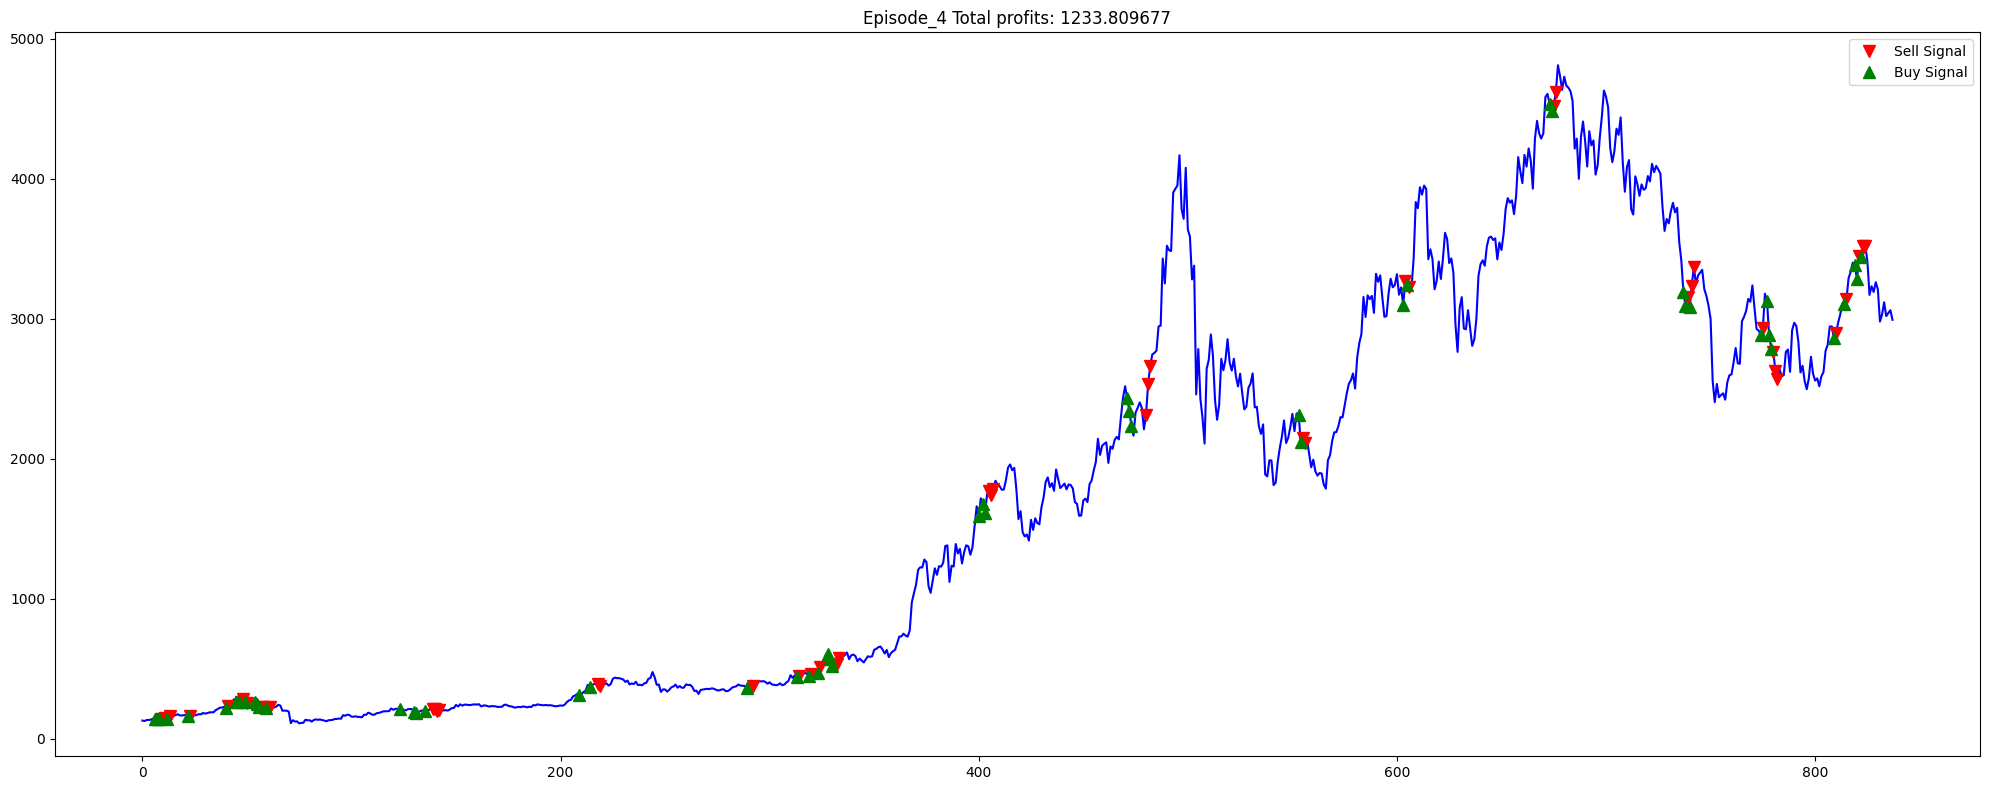

Running episode 5/15
--------------------------------
Total Profit: $1045.46
--------------------------------
Saving figure Episode_5


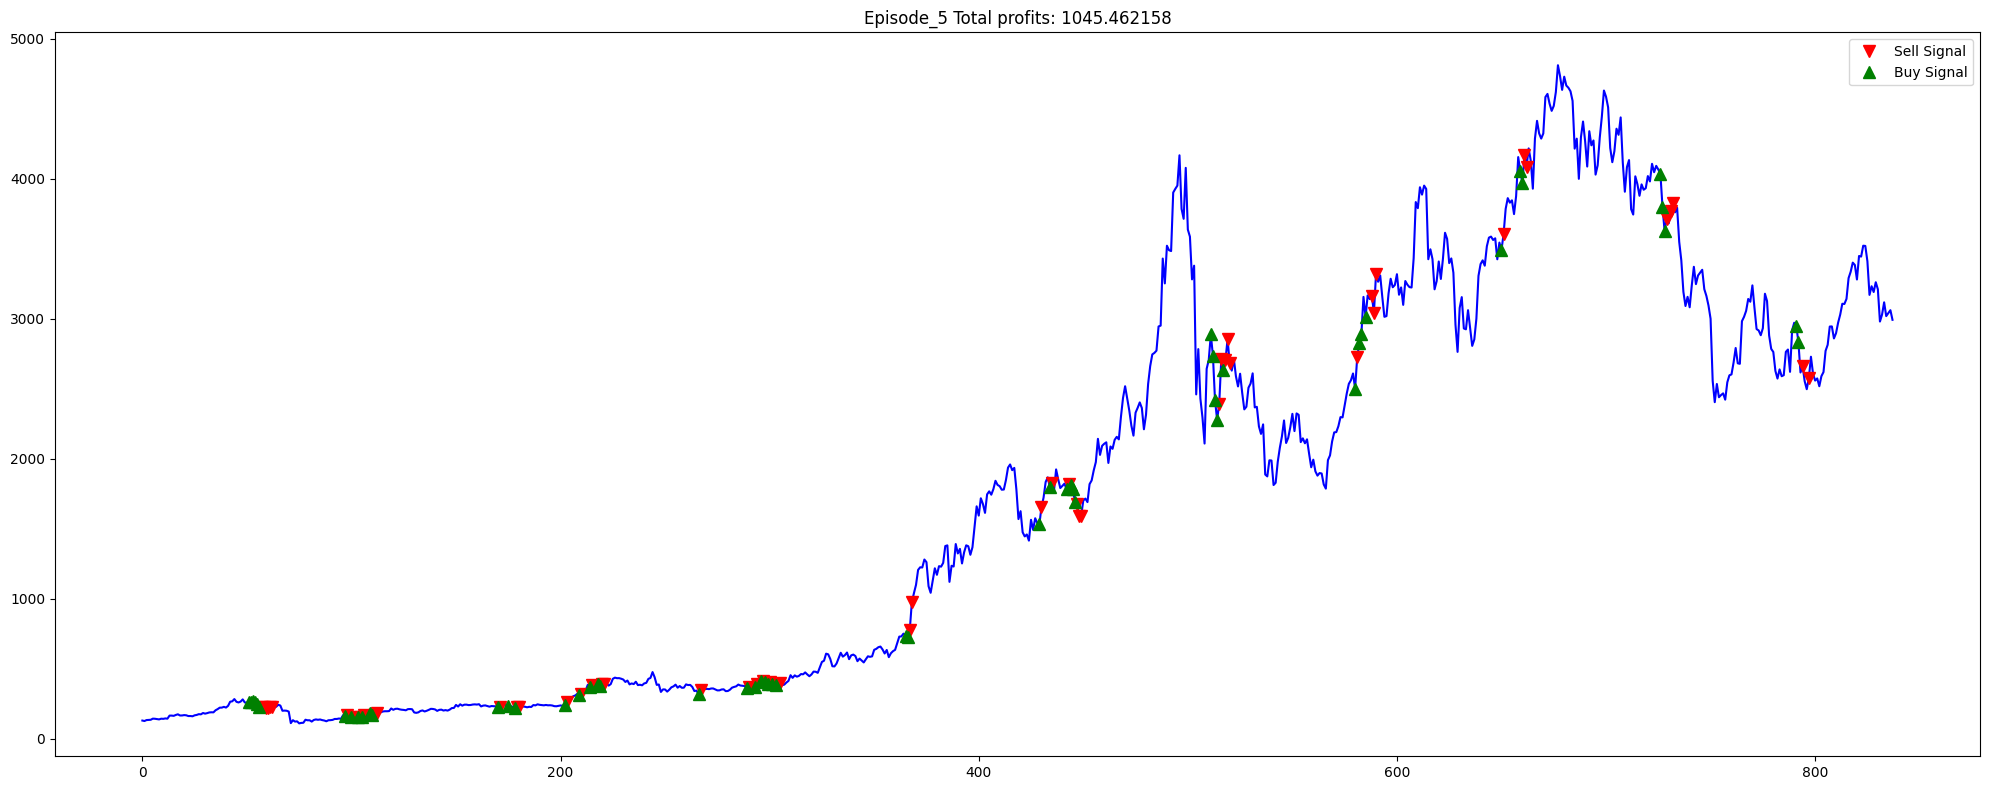

Running episode 6/15
--------------------------------
Total Profit: $7111.11
--------------------------------
Saving figure Episode_6


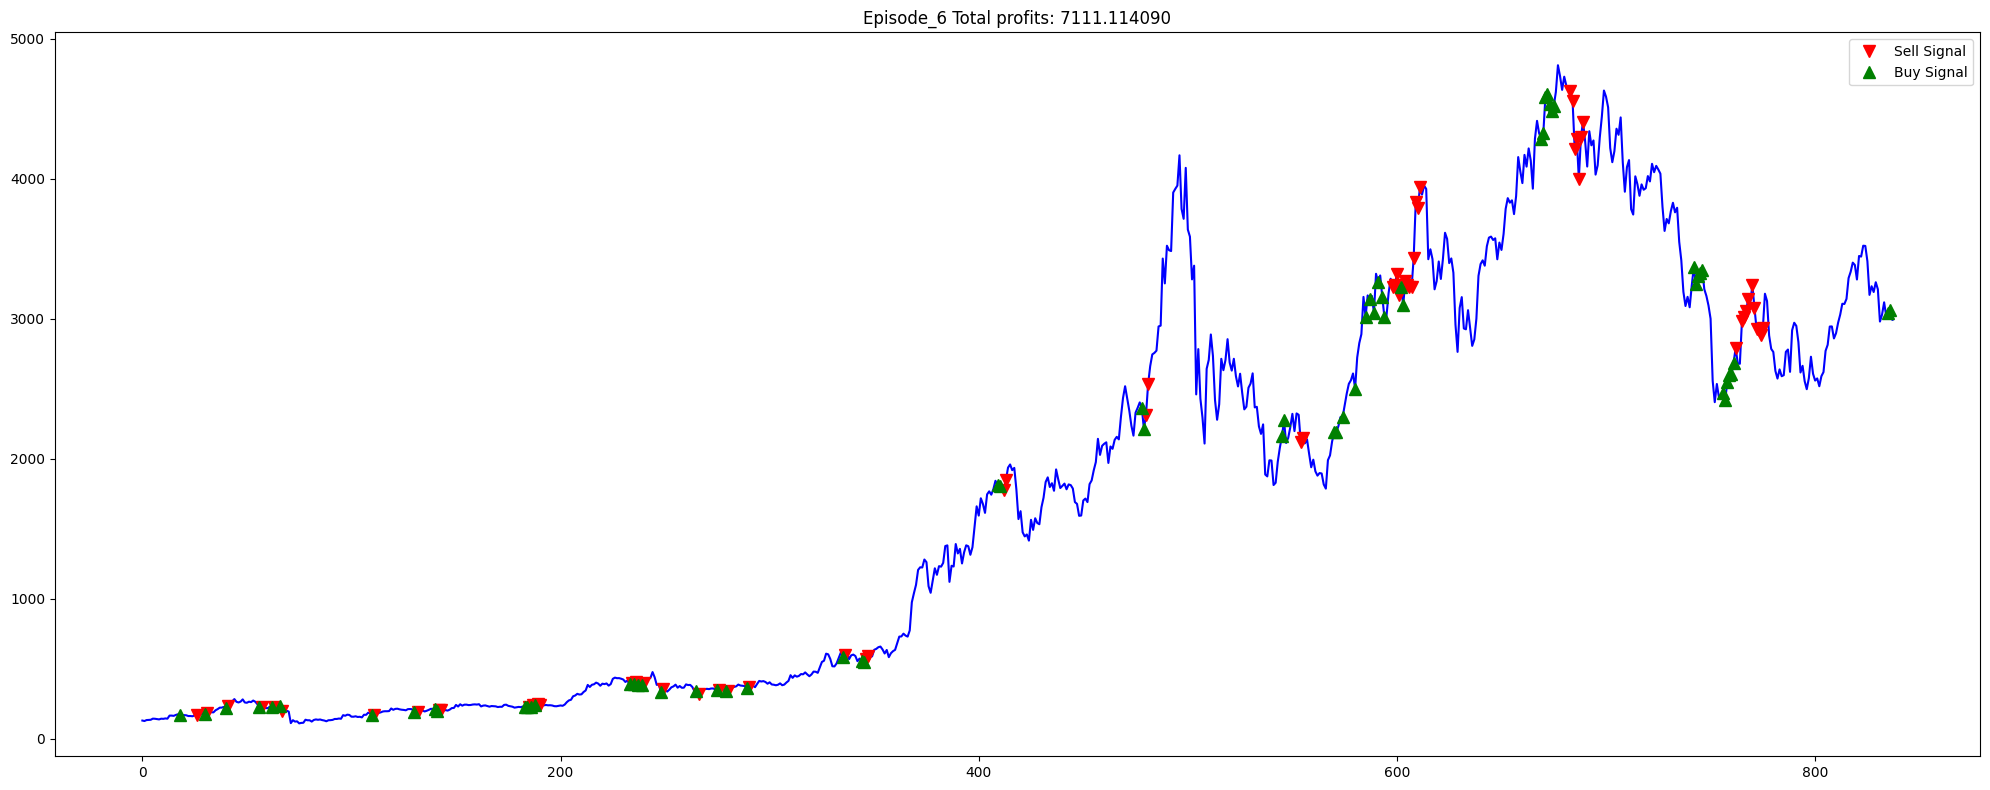

Running episode 7/15
--------------------------------
Total Profit: -$1864.23
--------------------------------
Saving figure Episode_7


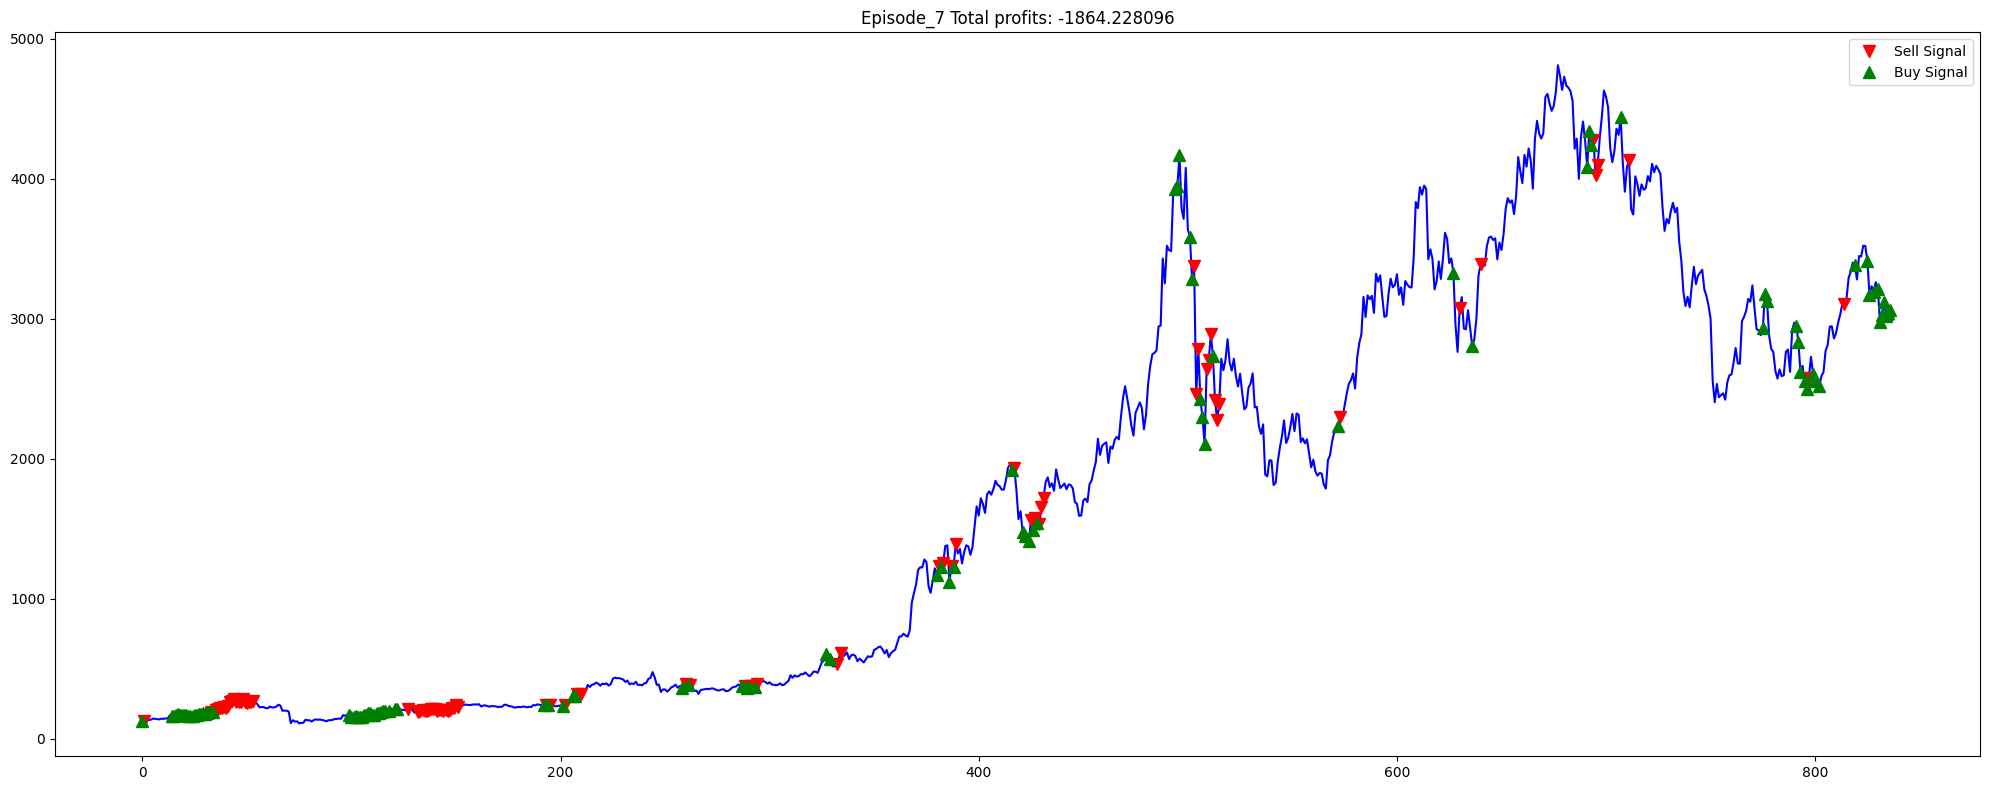

Running episode 8/15
--------------------------------
Total Profit: $146397.16
--------------------------------
Saving figure Episode_8


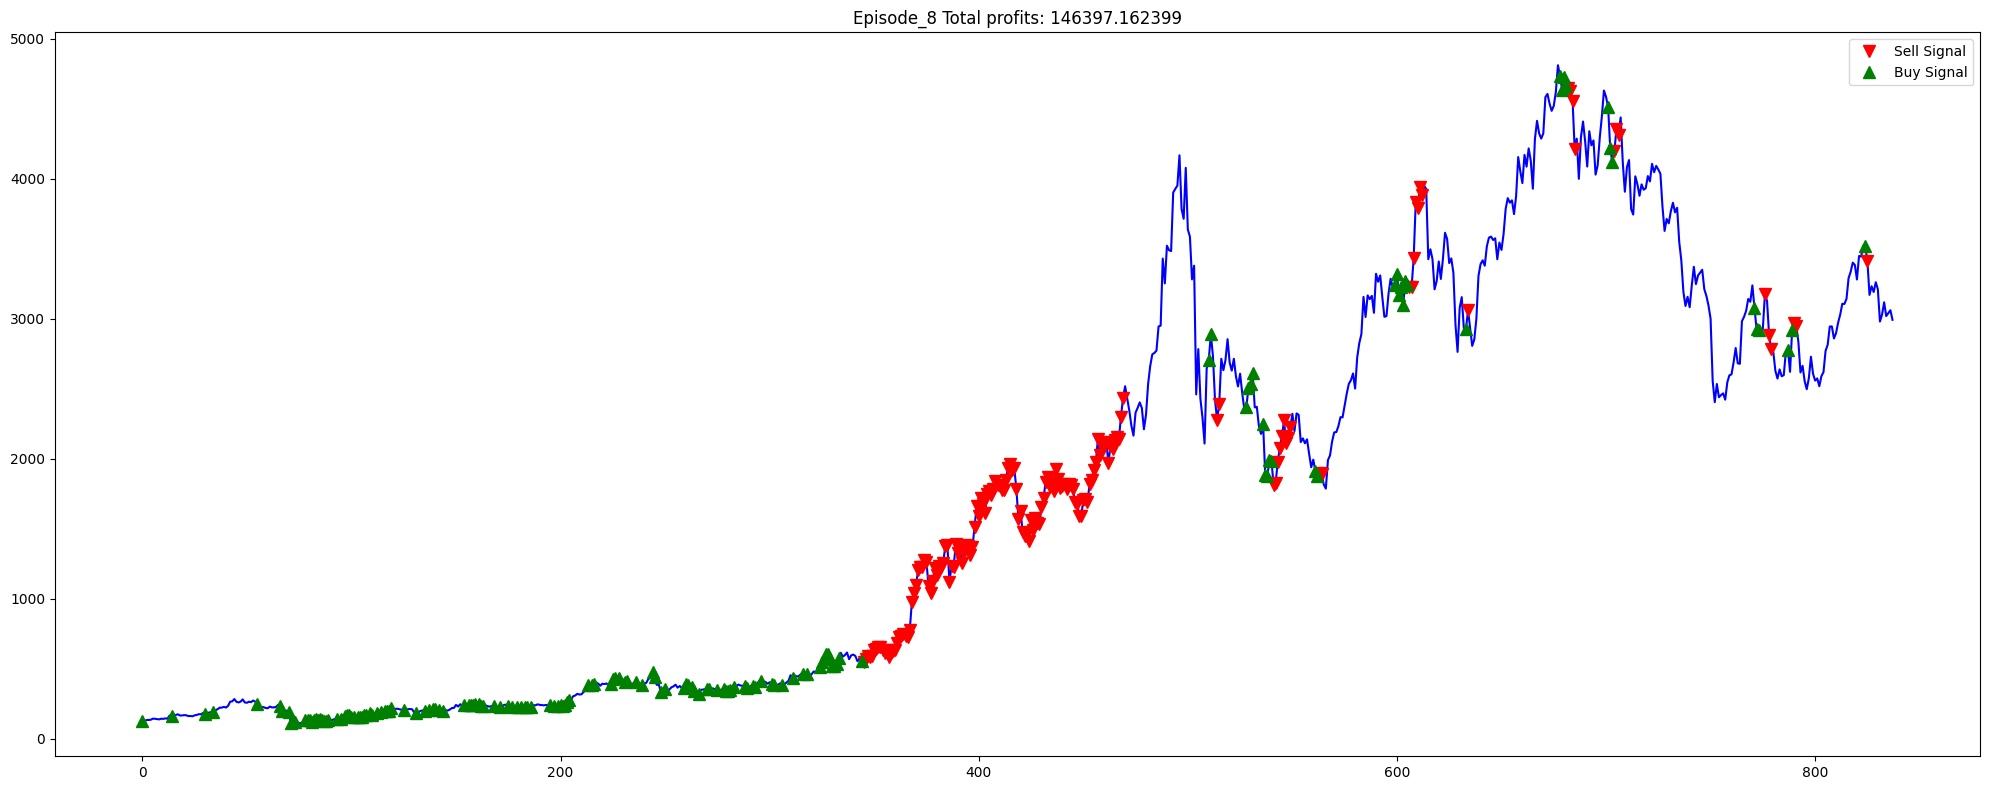

Running episode 9/15
--------------------------------
Total Profit: $2152.99
--------------------------------
Saving figure Episode_9


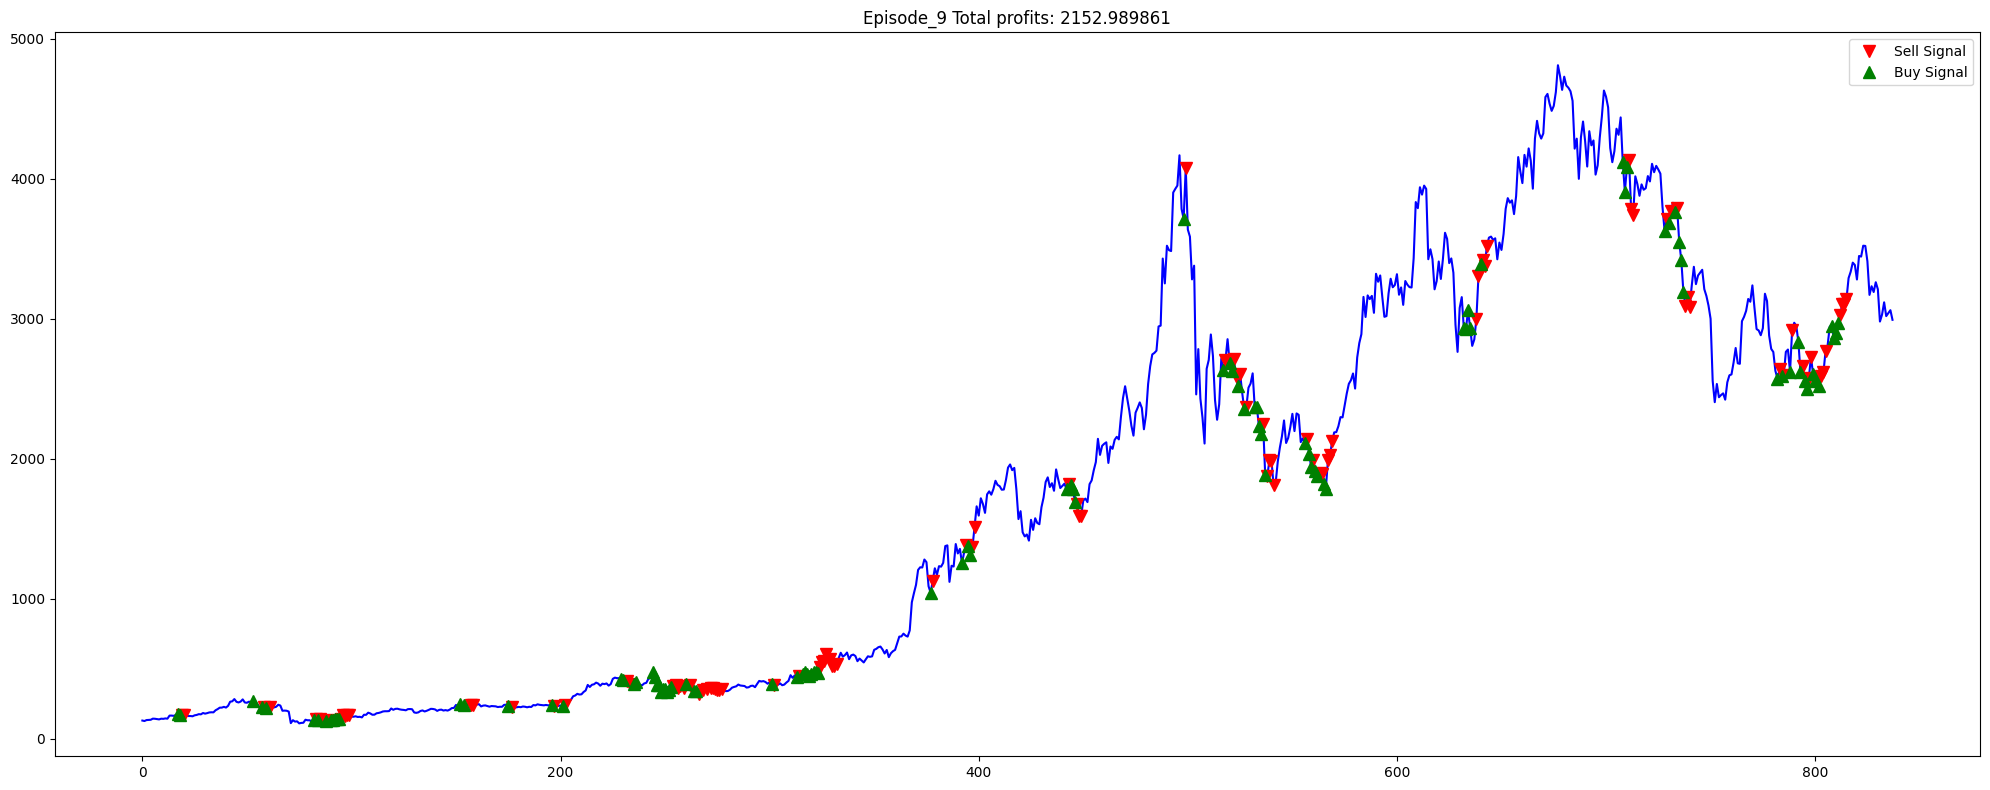

Running episode 10/15
--------------------------------
Total Profit: $3651.06
--------------------------------
Saving figure Episode_10


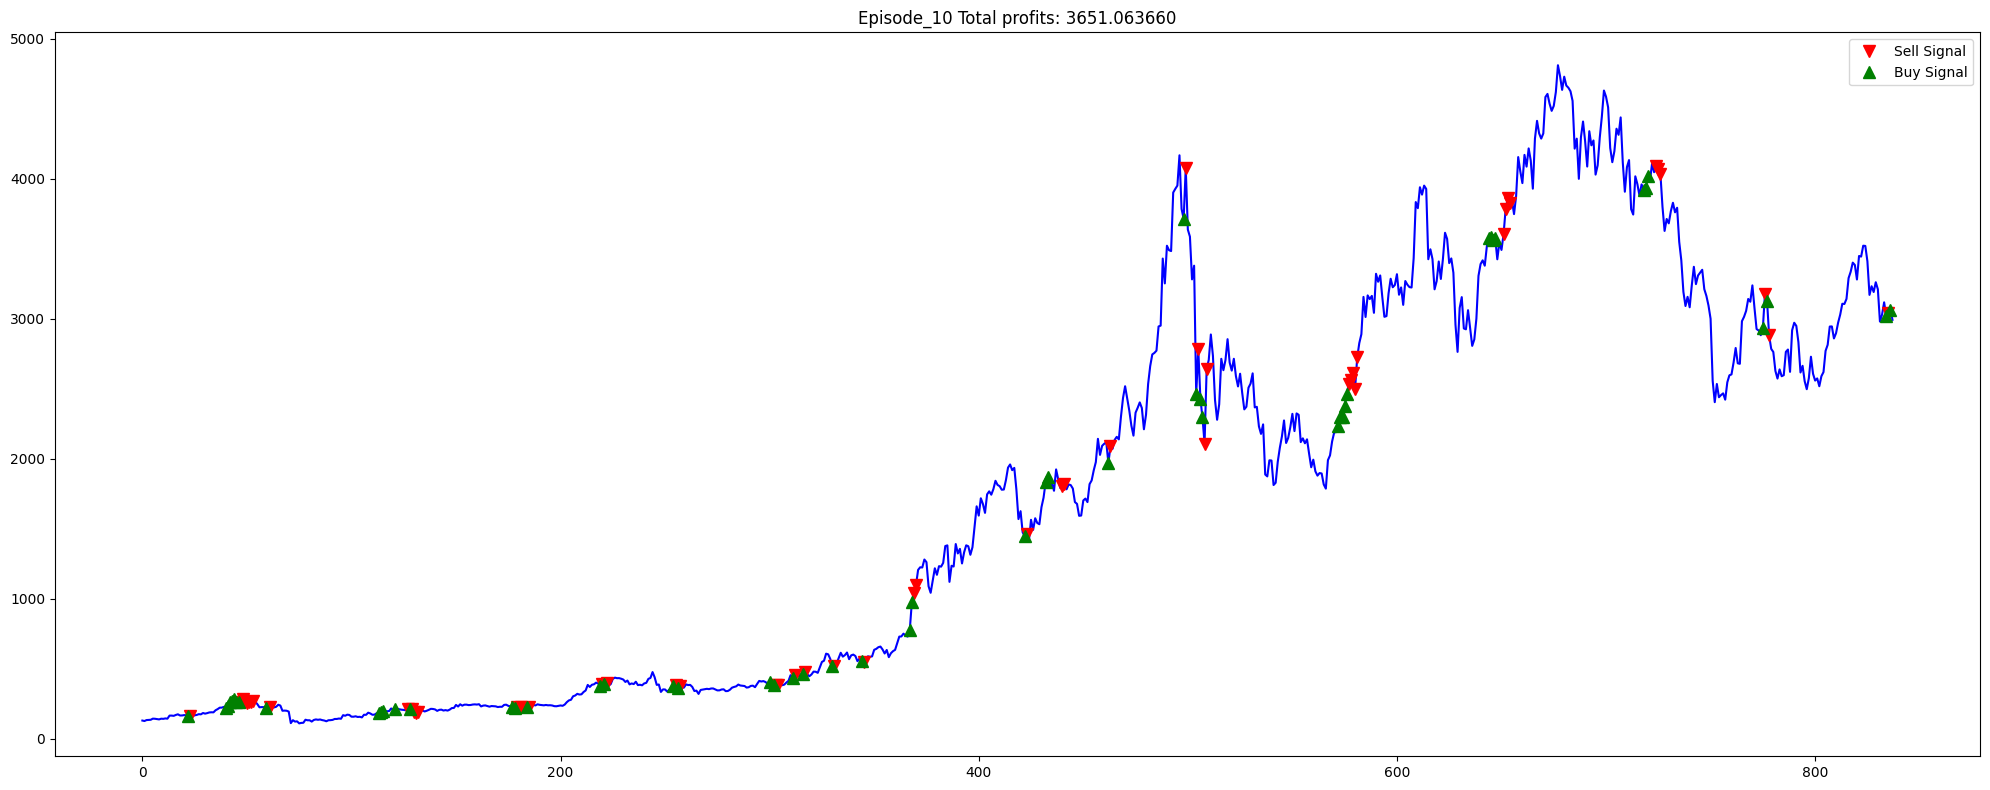

Running episode 11/15
--------------------------------
Total Profit: $1148.86
--------------------------------
Saving figure Episode_11


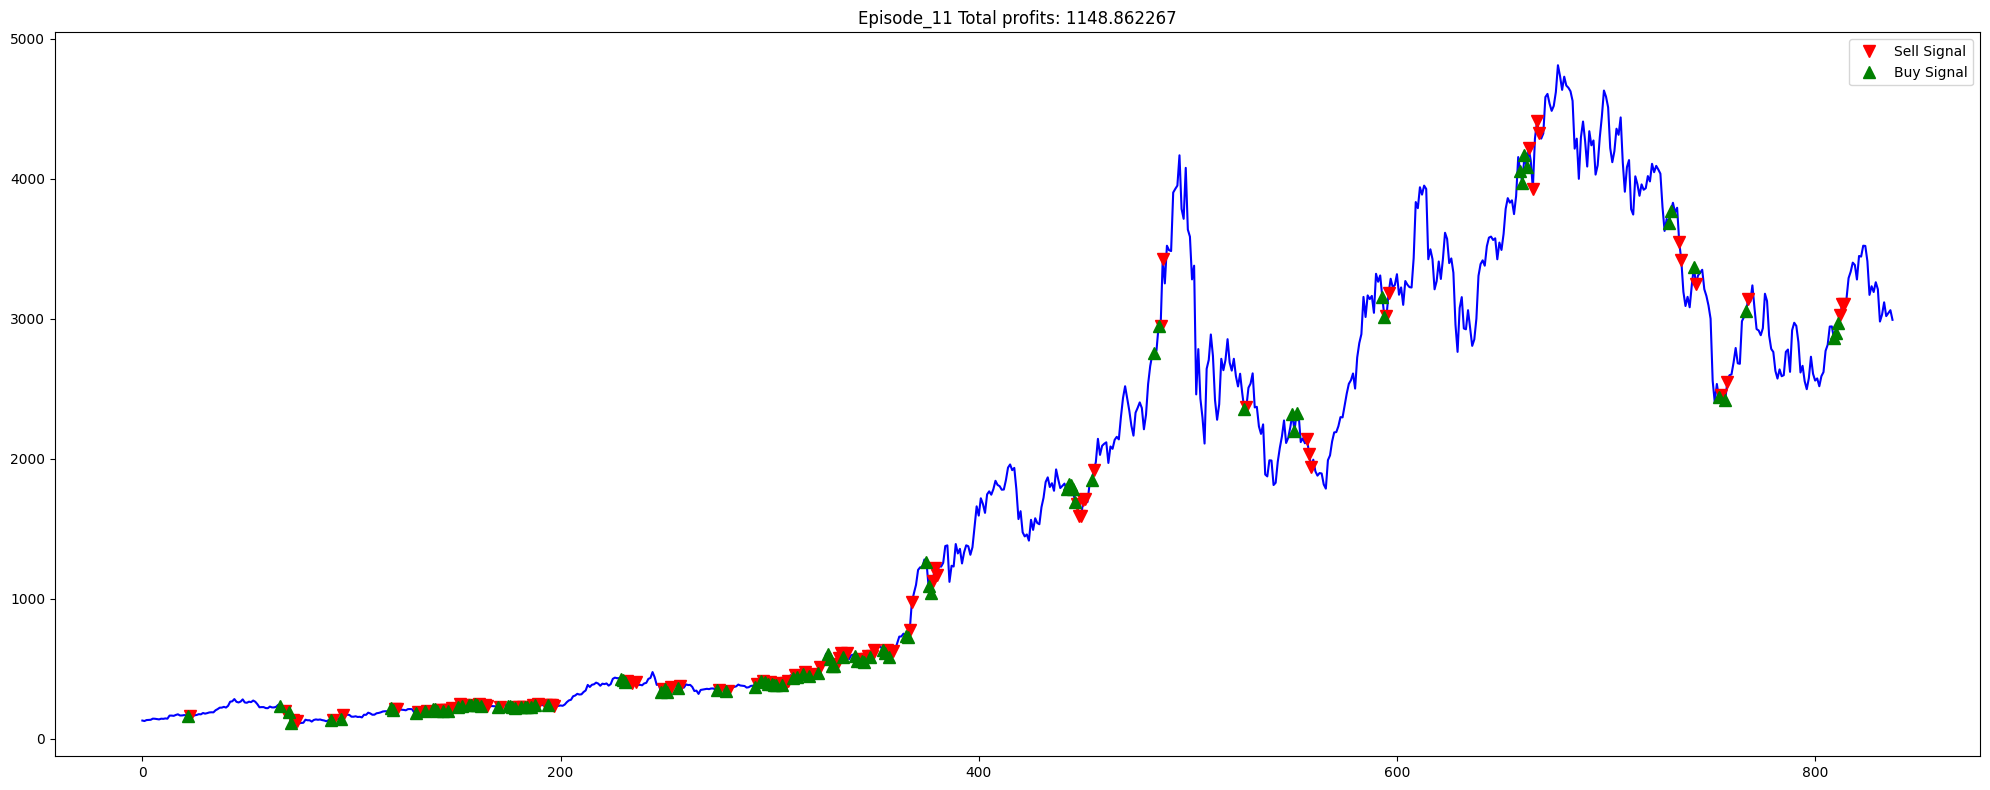

Running episode 12/15
--------------------------------
Total Profit: $812.77
--------------------------------
Saving figure Episode_12


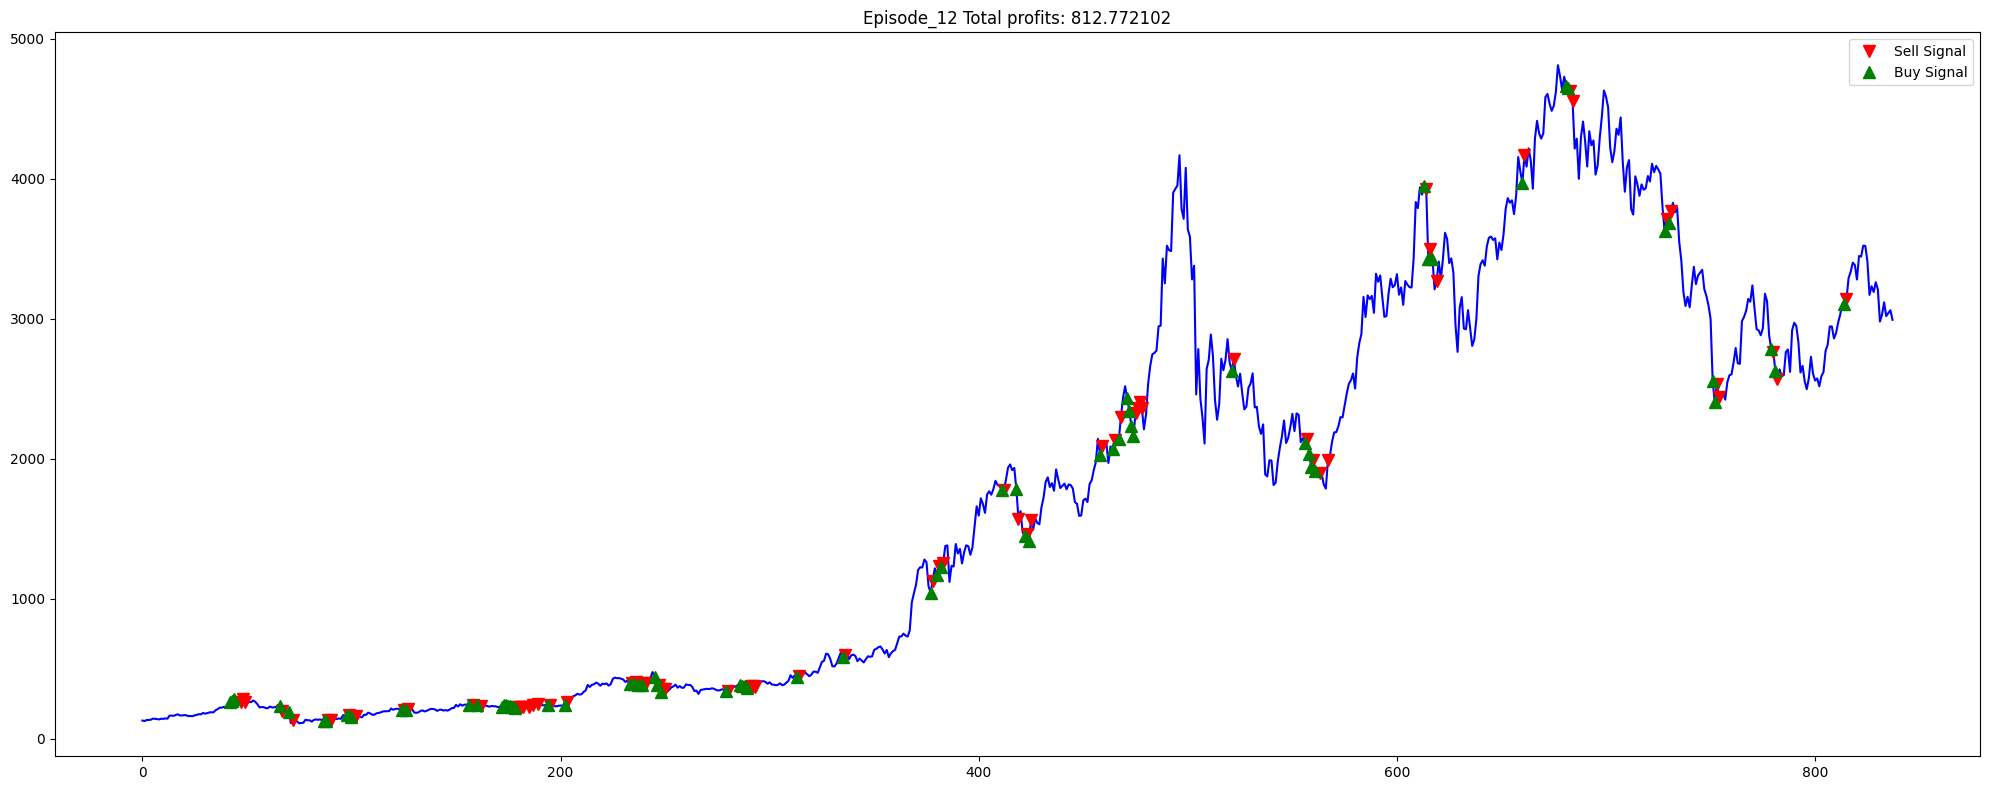

Running episode 13/15
--------------------------------
Total Profit: $2446.77
--------------------------------
Saving figure Episode_13


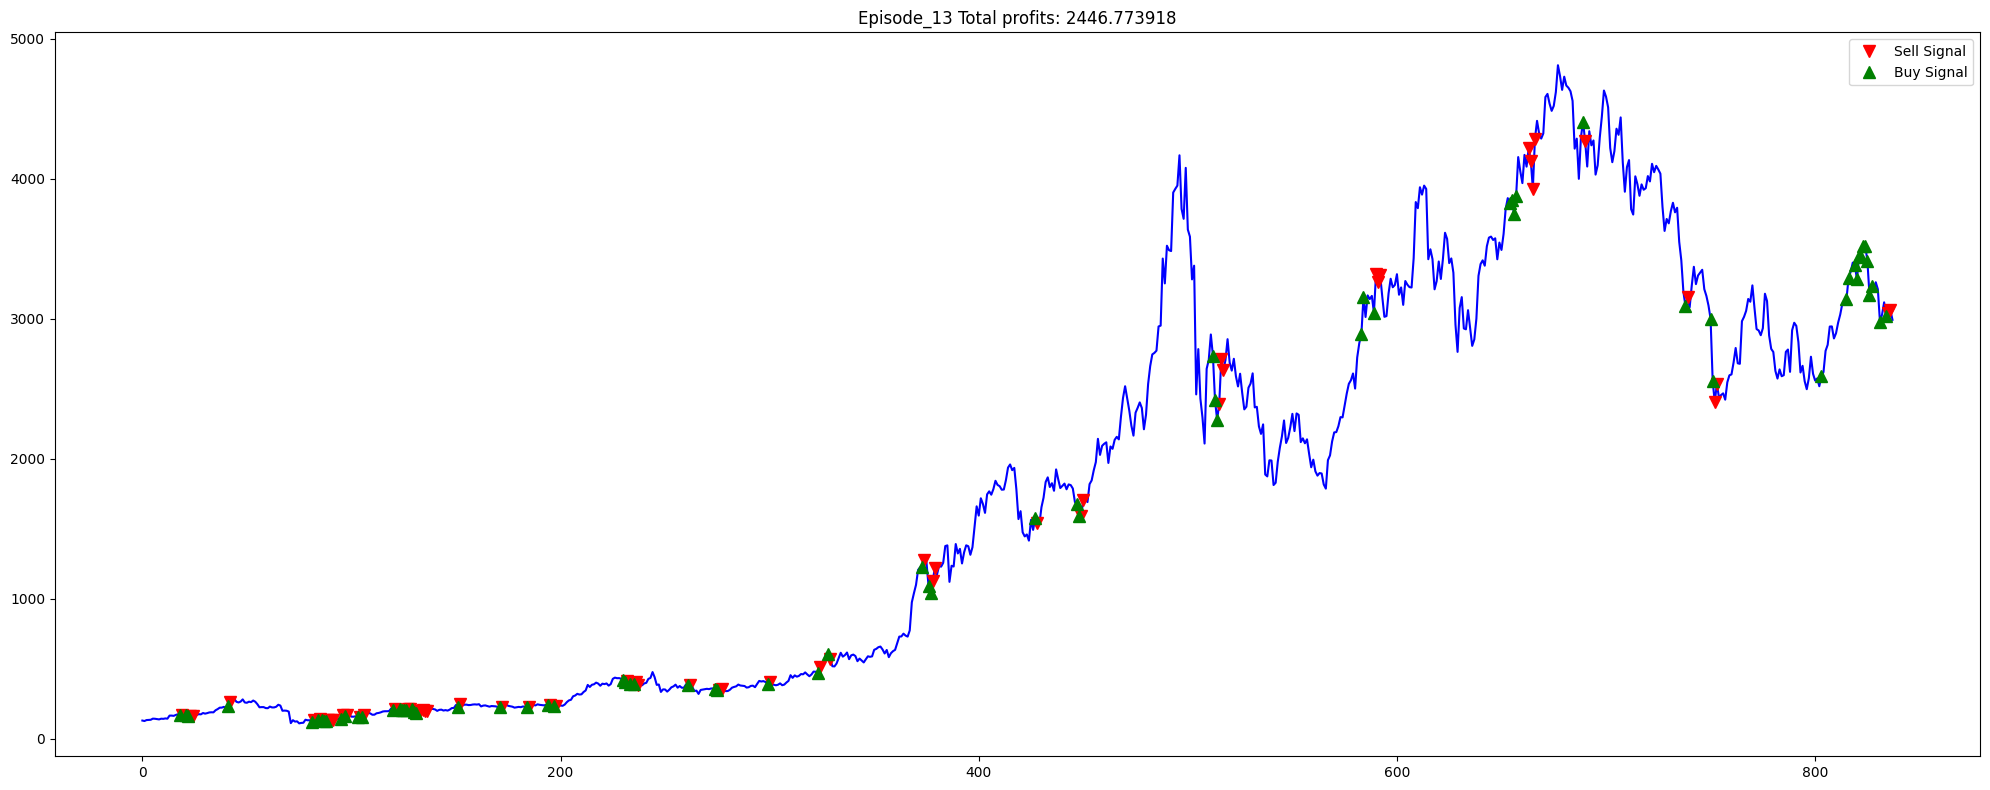

Running episode 14/15
--------------------------------
Total Profit: -$2166.63
--------------------------------
Saving figure Episode_14


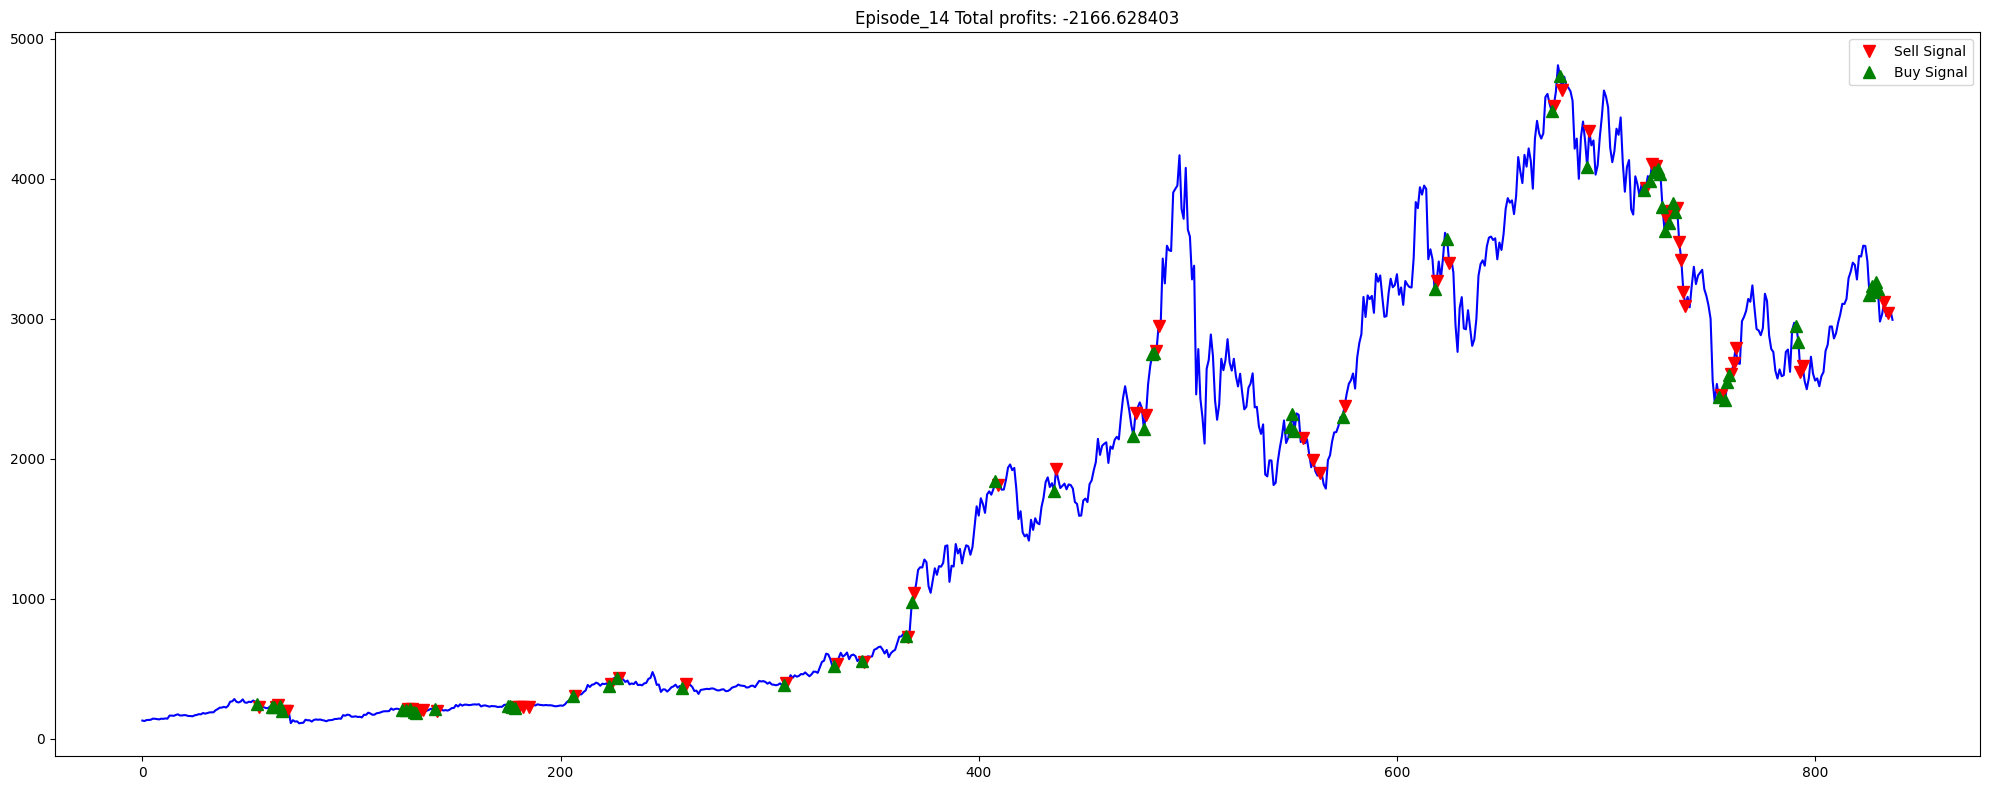

Running episode 15/15
--------------------------------
Total Profit: -$3892.51
--------------------------------
Saving figure Episode_15


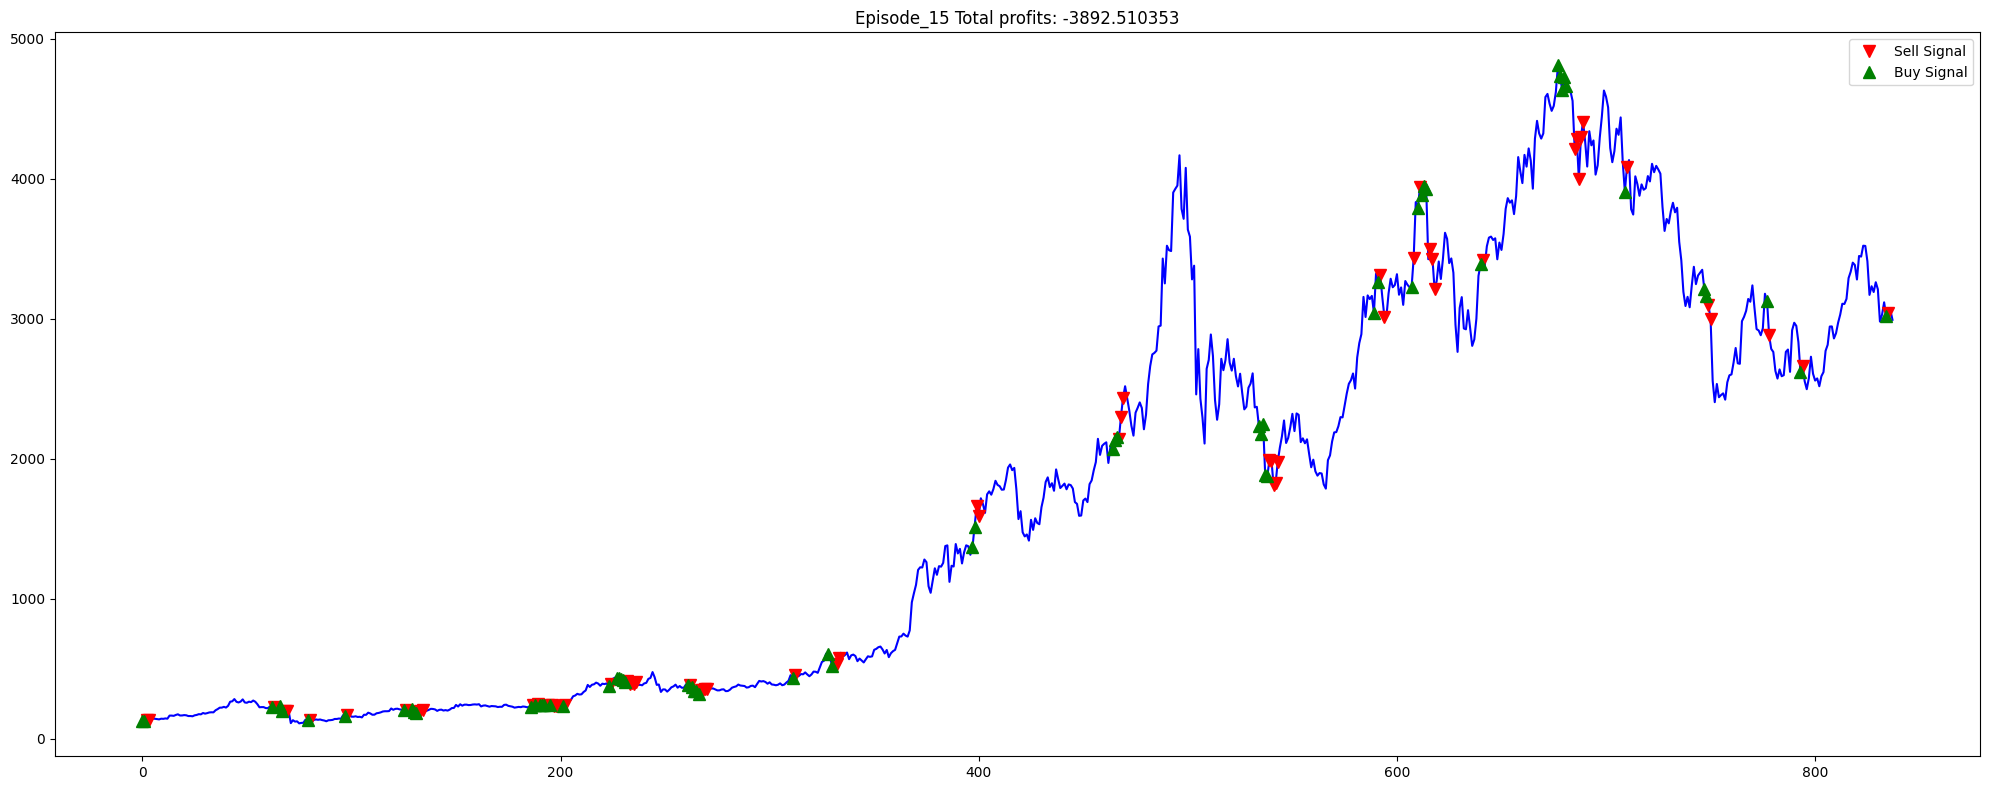

In [20]:
window_size = 1
agent = Agent(window_size)
data = X_train
l = len(data)-1
batch_size = 64
episode_count = 15

for e in range(episode_count+1):
    print("Running episode "+str(e)+"/"+str(episode_count))
    state = get_state(data, 0, window_size+1)
    total_profit = 0
    agent.inventory=[]
    buy_states = []
    sell_states = []

    for t in range(l):
        action = agent.actions(state)
        next_state = get_state(data, t+1, window_size+1)
        reward = 0
        if action == 1: # BUY ACTION AND ADD TO INVENTORY
            agent.inventory.append(data[t])
            buy_states.append(t)
#             print("Buy: " + formatPrice(data[t]))

        elif action == 2 and len(agent.inventory) > 0: # SELL ACTION IF YOU OWN ETH 
            bought_price = agent.inventory.pop(0)
            reward = max(data[t]-bought_price,0) 
            total_profit += data[t]-bought_price #Profit difference
            sell_states.append(t)
#             print("Sell: " + formatPrice(data[t]) + " | Profit: "+formatPrice(data[t]-bought_price))

        done = True if t == (l-1) else False
        #append the state action information in memory for exp_replay...
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state

        if done:
            print('--------------------------------')
            print('Total Profit: ' + formatPrice(total_profit))
            print('--------------------------------')
            
            plot_behavior(data, buy_states, sell_states, total_profit,'Episode_'+str(e))
        if len(agent.memory) > batch_size:
            agent.exp_replay(batch_size)
    agent.model.save('models/model_ep'+str(e))
        

The agent starts off not knowing about the consequences of actions, as it takes randomized actions to observe rewards associated with it. We did have a high profit in episode 0, but that's without knowing anything... until episode 1 where we had negative profits. We see the algorithm going through different approaches for progression. Towards the end, we see that it's learning pretty consistently throughout the training. Even though we had a good score in the beginning, doesn't mean it's "robust", we need stability and efficacy in the end results, otherwise it will overfit in the test set. Episode 5 seems like a good candidate.

Longer episode and batch size = longer training time

### Evaluate after finishing 1000 episodes... *IN PROGRESS*